<a href="https://colab.research.google.com/github/Zahra-FallahMMA/DeepLearning-Sharif/blob/main/1_MLP_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div dir=rtl>
<font size=5>
در این پروژه از شما انتظار داریم یک شبکه عصبی MLP را از پایه پیاده سازی کنید. در این پروژه شما مجاز به استفاده از هیچ library
(حتی numpy) نیستید. یک دیتاست فرضی روی شبکه خود در نظر بگیرید و سعی کنید خطا را روی آن کاهش دهید. y ها را برای
سادگی اسکالر در نظر بگیرید. در ادامه ساختار کد به شما نشان داده خواهد شد.
</div>
</font>

<div dir=rtl>
<font size=6>
مشتق گیری اتوماتیک
<div dir=rtl>
<font size=4>
اینگونه مشتق گرفتن دو روش اصلی به نام mode forward و mode reverse دارد. در پایتورچ از روش دوم استفاده میشود
و ماهم میخواهیم از روش دوم در این پروژه استفاده کنیم. برای یادگیری این موضوع تنها کافیست روی این <a href="https://auto-ed.readthedocs.io/en/latest/mod3.html#i-the-basics-of-reverse-mode">لینک</a> کلیک کنید وتنها قسمت Intuition for Example An .IV را تا آخر مرحله شش بخوانید.
در اصل شما باید داده ساختاری را در نظر بگیرید تا بتوانید گراف محاسباتی را تشکیل دهید و با صدا کردن تابع backward روی
خروجی شبکه ، مشتق خروجی را نسبت به تمامی وزن ها و بایاس های شبکه حساب کنید. (در اینجا شبکه ما تنها یک خروجی
دارد)

## Visualization Tool

In [ ]:
from graphviz import Digraph
import random
import math
from math import exp

def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})  # , node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label="{ %s | data %.4f | grad %.4f }" % (n.label, n.value, n.grad), shape='record')
        if n.operator:
            dot.node(name=str(id(n)) + n.operator, label=n.operator)
            dot.edge(str(id(n)) + n.operator, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.operator)

    return dot

## Tensor

In [ ]:
class Tensor:

  def __init__(self, value, label='', children=(), operator=None):
    self.value = value
    self.children = set(children)
    self.operator = operator
    self.grad = 0
    self._backward = lambda  : None
    self.label = label


  def __repr__(self) -> str:
    return f"Tensor(label = {self.label}, value = {self.value}, grad = {self.grad}, operator = {self.operator})"

  # normal add
  def __add__(self, other):

    other = other if isinstance(other, Tensor) else Tensor(other)

    out_value = self.value + other.value
    out = Tensor(out_value, children=(self, other), operator='+')

    def backward():
      self.grad = 1 * out.grad
      other.grad = 1 * out.grad

    out._backward = backward

    return out

  # reverse add
  def __radd__(self, other):
    return self + other

  def __sub__(self, other):

    other = other if isinstance(other, Tensor) else Tensor(other)

    out_value = self.value - other.value
    out = Tensor(out_value, children=(self, other), operator='-')

    def backward():
        self.grad += 1 * out.grad
        other.grad -= 1 * out.grad

    out._backward = backward
    return out


  def __mul__(self, other):

    other = other if isinstance(other, Tensor) else Tensor(other)

    out_value = self.value * other.value
    out = Tensor(out_value, children=(self, other), operator='*')

    def backward():
        self.grad += other.value * out.grad
        other.grad += self.value * out.grad

    out._backward = backward
    return out

  def __rmul__(self, other):
    return self * other


  def __truediv__(self, other):

    other = other if isinstance(other, Tensor) else Tensor(other)

    out_value = self.value / other.value
    out = Tensor(out_value, children=(self, other), operator='/')

    def backward():
        self.grad += (1 / other.value) * out.grad
        other.grad -= (self.value / (other.value ** 2)) * out.grad

    out._backward = backward
    return out


  def __pow__(self, other):
    assert isinstance(other, (int, float)), "Exponent must be a scalar."
    out_value = self.value ** other
    out = Tensor(out_value, children=(self,), operator=f'**{other}')

    def backward():
        self.grad += (other * (self.value ** (other - 1))) * out.grad

    out._backward = backward
    return out

# Activation Functions

In [ ]:
class F:

  @staticmethod
  def tanh(x: Tensor) -> Tensor:
    tanh_value = (math.exp(x.value) - math.exp(-x.value)) / (math.exp(x.value) + math.exp(-x.value))
    out = Tensor(tanh_value, children=(x,), operator='tanh')

    def backward():
      x.grad += (1 - tanh_value ** 2) * out.grad

    out._backward = backward
    return out

# Neuron, Layer & MLP (Forward Section)

In [ ]:
class Neuron:

  def __init__(self, input_size):

    self.weights = [Tensor(random.uniform(-1, 1)) for i in range(input_size)]
    self.bias = Tensor(random.uniform(-1, 1))

  def forward(self, x):

     weighted_sum = sum(w * xi for w, xi in zip(self.weights, x)) + self.bias
     output = F.tanh(weighted_sum)
     return output

  def __call__(self, x):
    return self.forward(x)

  def parameters(self):
    return self.weights + [self.bias]

  def __print__(self):
    weights_str = ', '.join(f'{w.value:.3f}' for w in self.weights)
    print(f'Neuron(weights=[{weights_str}], bias={self.bias.value:.3f})')

In [ ]:
class Layer:

  def __init__(self, input_size, output_size):
    self.neurons = [Neuron(input_size) for _ in range(output_size)]

  def forward(self, x):
    outputs = [neuron(x) for neuron in self.neurons]
    return outputs

  def __call__(self, x):
    return self.forward(x)

  def parameters(self):
    params = []
    for neuron in self.neurons:
        params.extend(neuron.parameters())
    return params

  def __print__(self):
    print(f'Layer with {len(self.neurons)} neurons:')
    for i, neuron in enumerate(self.neurons, start=1):
        print(f' Neuron {i}:')
        neuron.__print__()


<div dir=rtl>
<font size=4>
 کلاس MLP سه متود اصلی دارد که انتظار داریم با همین ساختار شما هم پیاده سازی خود را انجام دهید. متود forward محاسبات
را روی ورودی انجام میدهد و خروجی را برمیگرداند. متود __call __تنها متود forward را صدا میزند. در اصل ما دوست
داریم اینگونه (x(model ورودی را به مدل بدهیم. همچنین متود parameters تمامی وزن های شبکه را در لیست برمیگرداند.
<div dir=rtl>
<font size=4>
کلاس MLP خودش شامل چندین لایه یا همان Layer میشود که دقیقا همان لایه های شبکه عصبی ما هستند. هر لایه باید بداند
که دیتای ورودی چه ابعادی دارد و به چه ابعادی باید تبدیل شود. در اینجا ما ورودی هایمان همگی بردار هستند. هر Layer شامل
چندین Neuron هست. مثلا اگر قرار باشد در یک لایه از شبکه عصبی یک بردار ۷ تایی دریافت کنیم (سایز ورودی) و خروجی
یک بردار ۴ تایی داشته باشیم، باید در این لایه ۴ نورون بسازیم که هر نورون ۷ تا وزن و ۱ بایاس داشته باشد. جزییات و ساختار لایه
ها و نورون ها را متناسب با توضیحات گفته شده پیاده سازی کنید.
</div>
</font>

In [ ]:
class MLP:

  def __init__(self, input_size, layer_sizes):
    layers_total = [input_size] + layer_sizes
    self.layers = [Layer(layers_total[i], layers_total[i+1]) for i in range(len(layer_sizes))]

  def forward(self, x):
    for layer in self.layers:
        x = layer(x)
    return x

  def __call__(self, x):
    return self.forward(x)

  def parameters(self):
    params = []
    for layer in self.layers:
        params.extend(layer.parameters())
    return params

  def __print__(self):
    print(f"MLP with {len(self.layers)} layers:")
    for i, layer in enumerate(self.layers, start=1):
        print(f" Layer {i}:")
    layer.__print__()

# Optimizer

<div dir=rtl>
<font size=6>
بهینه کننده
<div dir=rtl>
<font size=4>
همانند پروژه اول optimzer باید به وزن های شبکه دسترسی داشته باشد و بتواند آن ها را این بار با توجه به مشتق شان و مقدار
پارامتر lr یا همان rate_learning اپدیت کند. کارکرد متود step همانند متود update در پروژه قبل میباشد. همچنین متودی
دیگری هم اضافه شده است به نام grad_zero که عملکرد آن توضیح داده شد.

In [ ]:
class Optimizer:

  def __init__(self, parameters, lr):
      self.parameters = parameters
      self.lr = lr

  def zero_grad(self):
      for param in self.parameters:
          param.grad = 0

  def step(self):
      for param in self.parameters:
          param.value -= self.lr * param.grad


# Training Part

In [ ]:
X = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

Y = [1.0, -1.0, -1.0, 1.0]

## Loss Function (SE)

In [ ]:
from typing import List

def criterion(y_hats: List[Tensor], Y) -> Tensor:
  return sum([(y_hat - y)**2 for y_hat, y in zip(y_hats, Y)])

## Training Loop

<div dir=rtl>
<font size=4>
• محاسبه پیش بینی های مدل: به ازای هر ورودی یا همان x ما مقدار خروجی توسط مدل یا همان hat_y را بدست می
آوریم.
<div dir=rtl>
<font size=4>
• محاسبه خطا: در اینجا شما باید خطای پیش بینی های خود را حساب کنید. برای راحتی کار تابع خطا را MSE در نظر
بگیرید.
<div dir=rtl>
<font size=4>
• صفر کردن مشتق متغیر های درون شبکه: در اینجا شما باید مشتق تمامی متغیرهای شبکه اتان را صفر کنید. پس از پیاده
سازی قسمت مشتق گیری اتوماتیک دلیل این کار را متوجه خواهید شد.
<div dir=rtl>
<font size=4>
• محاسبه مشتق: سخت ترین قسمت این پروژه پیاده سازی این قسمت میباشد. وقتی این تابع فراخوانی میشود باید مشتق
ⅼoss بر اساس تمامی وزن ها و بایاس های شبکه محاسبه شود. برای پیاده سازی این قسمت شما باید از Autoⅿatiⅽ
ⅾifferentiation یا به اختصار auto ⅾiff استفاده کنید.
<div dir=rtl>
<font size=4>
• بهبود وزن های شبکه: در این جا optimizer با توجه به داشتن مشتق loss نسبت به تمامی وزن ها و بایاس ها هر دو
را در جهتی بروزرسانی میکند که خطای بعدی ما کمتر شود

In [ ]:
def backward(output_tensor):
  # Step 1:
  visited = set()
  topo_order = []

  def build_topo(t):
      if t not in visited:
          visited.add(t)
          for child in t.children:
              build_topo(child)
          topo_order.append(t)

  build_topo(output_tensor)

  # Step 2:
  output_tensor.grad = 1

  # Step 3:
  for t in reversed(topo_order):
      t._backward()


Epoch 1/300, Loss: 1.0605846520861586
Epoch 2/300, Loss: 1.0551965396797334
Epoch 3/300, Loss: 1.0500452796458226
Epoch 4/300, Loss: 1.0451192579720385
Epoch 5/300, Loss: 1.040406743016427
Epoch 6/300, Loss: 1.027503338036214
Epoch 7/300, Loss: 1.015555695755073
Epoch 8/300, Loss: 1.012217822190367
Epoch 9/300, Loss: 1.0014084805771646
Epoch 10/300, Loss: 0.9914848357447812
Epoch 11/300, Loss: 0.9891932714469095
Epoch 12/300, Loss: 0.9802138736461239
Epoch 13/300, Loss: 0.9783290106705321
Epoch 14/300, Loss: 0.9701795322322881
Epoch 15/300, Loss: 0.9685983929620755
Epoch 16/300, Loss: 0.9611661875172306
Epoch 17/300, Loss: 0.9597960557738461
Epoch 18/300, Loss: 0.9583876391928595
Epoch 19/300, Loss: 0.9515221515631855
Epoch 20/300, Loss: 0.9452430236186533
Epoch 21/300, Loss: 0.9440691111432942
Epoch 22/300, Loss: 0.9428279346331623
Epoch 23/300, Loss: 0.9368490398576668
Epoch 24/300, Loss: 0.9356016306469372
Epoch 25/300, Loss: 0.9299559357430669
Epoch 26/300, Loss: 0.9248265980844708

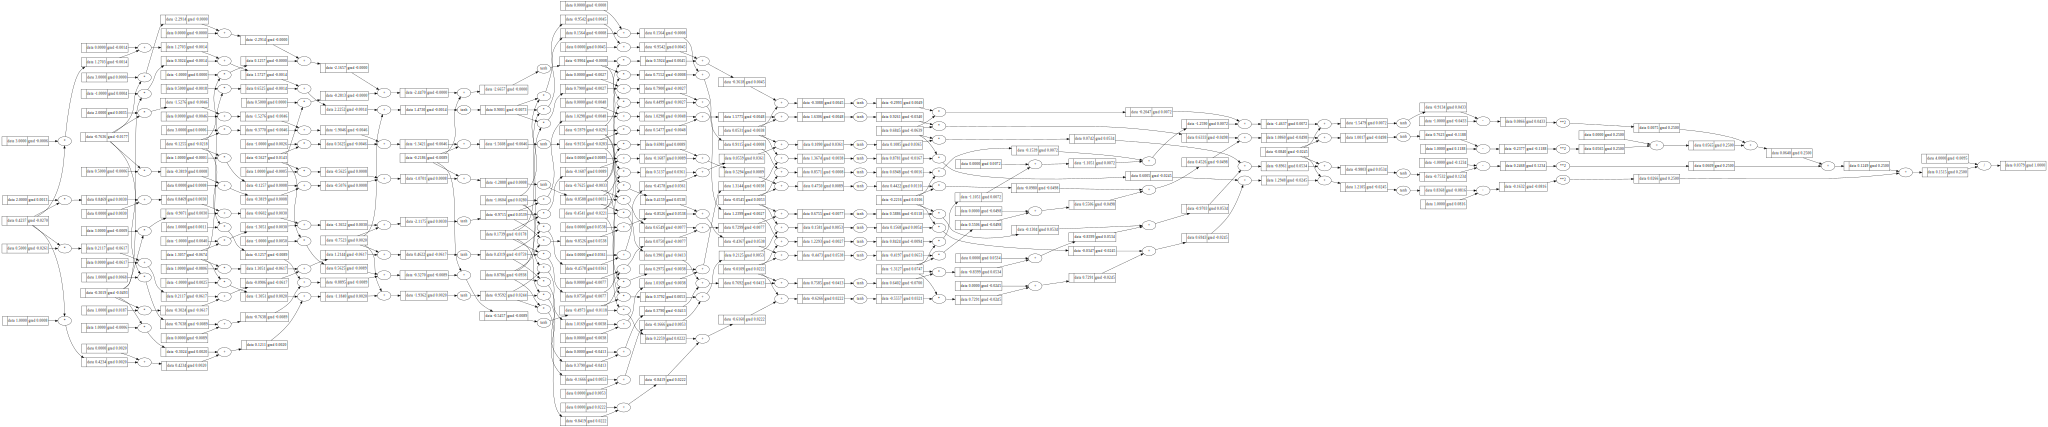

In [ ]:
n_epochs = 300

input_size = 3 # Number of features in the input layer
layer_sizes = [2, 3, 1] # Number of neurons in each hidden and output layer
model = MLP(input_size, layer_sizes)
optim = Optimizer(model.parameters(), lr=0.01)

for epoch in range(n_epochs):
  # Forward pass: Compute predictions for the entire dataset
  y_hats = [model(x)[0] for x in X]

  # Compute the loss
  loss = criterion(y_hats, Y)/len(Y)

  # Zero the gradients to prevent accumulation from previous iterations
  optim.zero_grad()

  # Backward pass: Compute the gradient of the loss function with respect to model parameters
  backward(loss)

  # Update the model parameters using the optimizer
  optim.step()

  print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.value}")

draw_dot(loss)